## Conversational RAG

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich
from datetime import datetime


from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")
WS_API_TOKEN = os.getenv("WS_API_TOKEN")

In [2]:
import json

from typing import List, Optional
from haystack.utils import Secret
from haystack import Pipeline, component, Document
from haystack.components.builders import PromptBuilder
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.components.routers import ConditionalRouter
from haystack.components.websearch.serper_dev import SerperDevWebSearch 

from haystack import Pipeline
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator
from haystack.evaluation import EvaluationRunResult



In [3]:
from haystack.components.converters import OutputAdapter

In [4]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()


converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"converter": {"sources": ["../data/tolkien.txt",
                                                 "../data/George_RR_Martin.txt"]}})


No abbreviations file found for en. Using default abbreviations.
Batches: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


{'writer': {'documents_written': 92}}

In [5]:
@component
class QueryExpander:

    def __init__(self, open_ai_key: str , prompt: Optional[str] = None, model: str = "gpt-4o-mini"):

        self.query_expansion_prompt = prompt
        self.model = model
        self.open_ai_key = open_ai_key
        if prompt == None:
          self.query_expansion_prompt = """
          You are part of an information system that processes users queries.
          You expand a given query into {{ number }} queries that are similar in meaning.

          Structure:
          Follow the structure shown below in examples to generate expanded queries.
          The idea is to obtain as output a string containing a list with {{ number }} queries.

          Examples:
          Query: "climate change effects"
          Output: ["impact of climate change", "consequences of global warming", "effects of environmental changes"]

          Query: ""machine learning algorithms""
          Output: ["neural networks", "clustering", "supervised learning", "deep learning"]

          Query: "renewable energy sources"
          Output: ["solar power", "wind energy", "hydropower", "benefits of renewable energy", "green energy technologies"]

          Query: "mental health in adolescents"
          Output: ["teen depression", "anxiety in teenagers", "mental health support for youth", "effects of social media on mental health", "counseling for adolescents"]

          Query: "cybersecurity risks"
          Output: ["data breaches", "phishing attacks", "network security threats", "cybersecurity best practices", "malware protection"]

          Your Task:
          Query: "{{query}}"
          Output:
          """
        builder = PromptBuilder(self.query_expansion_prompt)
        llm = OpenAIGenerator(model = self.model, api_key = self.open_ai_key)
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(queries=List[str])
    def run(self, query: str, number: int = 5):
        result = self.pipeline.run({'builder': {'query': query, 'number': number}})
        expanded_query = json.loads(result['llm']['replies'][0]) + [query]
        
        return {"queries": list(expanded_query)}

In [6]:
@component
class MultiQueryInMemoryEmbeddingRetriever:

    def __init__(self, retriever: InMemoryEmbeddingRetriever,  top_k: int = 3):
        self.retriever = retriever
        self.embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
        self.results = []
        self.ids = set()
        self.top_k = top_k

        self.pipeline = Pipeline()
        self.pipeline.add_component(name="embedder", instance=self.embedder)
        self.pipeline.add_component(name="retriever", instance=self.retriever)
        self.pipeline.connect("embedder", "retriever")
        

    def add_document(self, document: Document):
        if document.id not in self.ids:
            self.results.append(document)
            self.ids.add(document.id)

    @component.output_types(documents=List[Document])
    def run(self, queries: List[str], top_k: int = None):
        if top_k != None:
          self.top_k = top_k
        for query in queries:
          result = self.pipeline.run({"embedder": {'text':query}, "retriever": {"top_k": self.top_k}})
          for doc in result['retriever']['documents']:
            self.add_document(doc)
        self.results.sort(key=lambda x: x.score, reverse=True)
        return {"documents": self.results}

In [7]:
system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. 

If the answer is not contained within the documents, reply with 'no_answer'.

    Conversation history:
    {% for memory in memories %}
        {{ memory.text }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

user_message = ChatMessage.from_user(user_message_template)

In [8]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        If the answer is not contained within the documents, reply with 'no_answer'.

        Conversation history:
        {% for memory in memories %}
            {{ memory.text }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

In [9]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch", 
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

In [10]:
system_message_for_web = ChatMessage.from_system("""You are a helpful AI assistant using provided supporting documents from web to assist humans""")

prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

prompt_for_websearch = ChatMessage.from_user(prompt_for_websearch)

In [11]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


chat_agent = Pipeline()
chat_agent.add_component("expander", QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
chat_agent.add_component("query_rephrase_llm", OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))
chat_agent.add_component("retriever", MultiQueryInMemoryEmbeddingRetriever(retriever=InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3)))
chat_agent.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
chat_agent.add_component("generator", chat_generator)
chat_agent.add_component("router", ConditionalRouter(routes=routes))
chat_agent.add_component("websearch", SerperDevWebSearch(api_key=Secret.from_token(WS_API_TOKEN))) 
chat_agent.add_component("prompt_builder_for_websearch", ChatPromptBuilder(variables=["query", "documents"], required_variables=["query", "documents"]))
chat_agent.add_component("llm_for_websearch",  OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))


chat_agent.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
chat_agent.connect("query_rephrase_llm.replies", "list_to_str_adapter")
chat_agent.connect("list_to_str_adapter.output", "expander")
chat_agent.connect("expander.queries", "retriever.queries")
chat_agent.connect("retriever.documents", "prompt_builder.documents")
chat_agent.connect("prompt_builder.prompt", "generator.messages")
chat_agent.connect("generator.replies", "router.replies")
chat_agent.connect("router.go_to_websearch", "websearch.query")
chat_agent.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
chat_agent.connect("websearch.documents", "prompt_builder_for_websearch.documents")
chat_agent.connect("prompt_builder_for_websearch.prompt", "llm_for_websearch.messages")




🚅 Components
  - expander: QueryExpander
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - retriever: MultiQueryInMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
  - router: ConditionalRouter
  - websearch: SerperDevWebSearch
  - prompt_builder_for_websearch: ChatPromptBuilder
  - llm_for_websearch: OpenAIChatGenerator
🛤️ Connections
  - expander.queries -> retriever.queries (List[str])
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> expander.query (str)
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])
  - generator.replies -> router.replies (List[ChatMessage])
  - router.go_to_websearch -> websearch.query (str)
  - router.go_to_websear

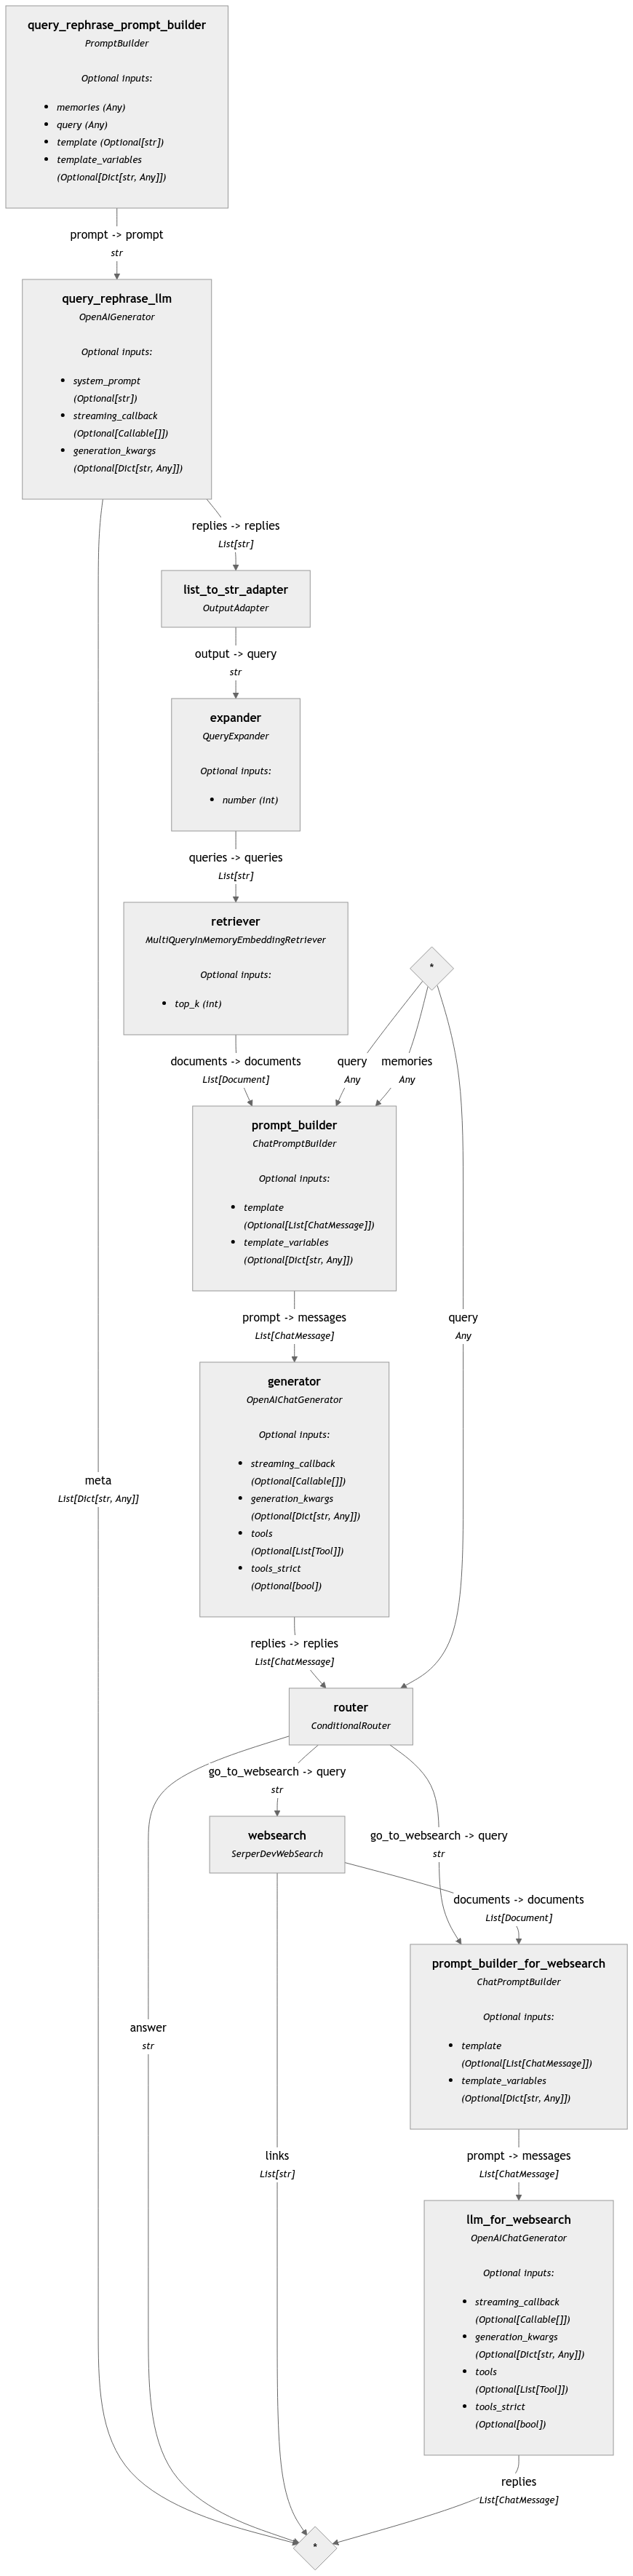

In [12]:
chat_agent.show()

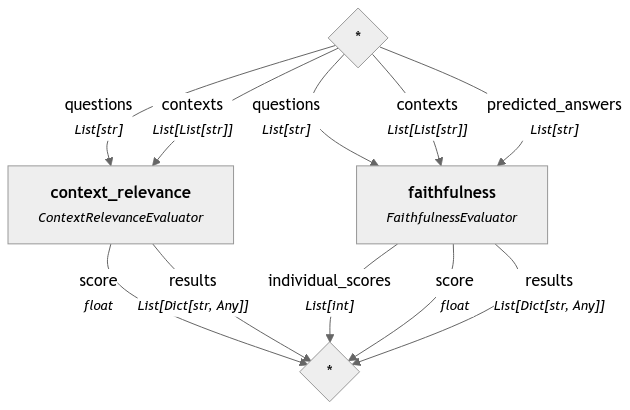

In [13]:
eval_pipeline = Pipeline()
eval_pipeline.add_component("context_relevance", ContextRelevanceEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar=True, raise_on_failure=False))
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar = True, raise_on_failure=False))

eval_pipeline.show()

In [14]:
messages = []
template = [system_message, user_message]
template_web = [system_message_for_web, prompt_for_websearch]

questions = []
retrieved_documents = []
predicted_answers = []
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    print(user_input)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    response = chat_agent.run({"query_rephrase_prompt_builder": {"query": user_input, "memories":messages}, 
                               "prompt_builder": {"template":template, "query": user_input, "memories":messages},
                               "router": {"query": user_input},
                               "prompt_builder_for_websearch": {"template":template_web,}},
                                include_outputs_from={"expander", "generator", "router", "retriever"})
    if response['generator']['replies'][0].text != 'no_answer':
        messages.append(ChatMessage.from_user(user_input))
        messages.extend(response['generator']['replies'])
        questions.append(user_input)
        retrieved_documents.append(response['retriever']['documents'])
        predicted_answers.append(response["generator"]["replies"][0])
        print(response['generator']['replies'][0].text)
        if len(questions)%5==0:
            eval_pipeline_results = eval_pipeline.run(
                {"context_relevance": {"questions": questions, "contexts": retrieved_documents},
                 "faithfulness": {"questions": questions, "contexts": retrieved_documents, "predicted_answers": predicted_answers},})
            results = {"context_relevance": eval_pipeline_results['context_relevance'],
                        "faithfulness": eval_pipeline_results['faithfulness'],}
            inputs = {'questions': questions, 'contexts': retrieved_documents, 'predicted_answers': predicted_answers}
            eval_results = EvaluationRunResult(run_name="rag_eval", inputs=inputs, results=results)
            eval_results.score_report().to_csv("evaluation_reports/evaluation_report_overall_score.csv")
            eval_results.to_pandas().to_csv("evaluation_reports/evaluation_report_case_by_case.csv")
    else:
        messages.append(ChatMessage.from_user(user_input))
        messages.extend(response['llm_for_websearch']['replies'])
        print(response['llm_for_websearch']['replies'][0].text)






who is tolkien?


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.17it/s]


John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.
exit


In [15]:
response

{'query_rephrase_llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 9,
     'prompt_tokens': 106,
     'total_tokens': 115,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'router': {'answer': "ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 50, 'prompt_tokens': 488, 'total_tokens': 538, 'completion_tokens_details': CompletionTokensDetail

In [16]:
messages

[ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='who is tolkien?')], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 50, 'prompt_tokens': 488, 'total_tokens': 538, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}})]